In [9]:
import mdtraj as md
import pyemma as pm

import openpathsampling as ops
import openpathsampling.visualize as ops_vis

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import sys
from pathlib import Path
import os
import pickle
import pandas 
import numpy as np
from IPython.display import SVG
from tqdm import tqdm

In [10]:
title = 'CLN_dbscan(0.06,50)_tps'
model_path = Path(r'./data/CLN_msm/')
storage_path = Path(f'./data/{title}')
results_path = Path(f'./results/{title}')
fig_path = results_path.joinpath('fig')
fig_path.mkdir(parents=True, exist_ok=True)

top_path = Path('./data/CLN_msm//protein.pdb')
traj_paths = [str(x) for x in Path(r'./data/CLN_msm/').rglob(f'CLN025-0-protein-*.xtc')]
traj_paths.sort()

# import cvs from file
sys.path.append(str(storage_path))
from cv import *

frame_interval = 1 #ps

In [11]:
# Load storage in read-only way
storage = ops.AnalysisStorage(storage_path.joinpath(f'{title}.nc'))
engine = storage.engines[1] 
scheme = storage.schemes[0]
scheme.move_summary(storage.steps)
print("File size: {0} for {1} steps, {2} snapshots".format(
    storage.file_size_str,
    len(storage.steps),
    len(storage.snapshots)))

  0%|          | 0/5 [00:00<?, ?it/s]

shooting ran 100.000% (expected 100.00%) of the cycles with acceptance 0/4 (0.00%)
File size: 564.22MB for 5 steps, 6078 snapshots


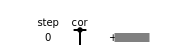

In [12]:
# To visualize the time evolution of samples using pathtree

tree_head = ops_vis.PathTree(
            storage.steps[:],
            ops_vis.ReplicaEvolution(replica=0))
'''
tree_full = ops_vis.PathTree(
            storage.steps,
            ops_vis.ReplicaEvolution(replica=0))
'''
SVG(tree_head.svg())

In [ ]:
# Identify the first decorrelation

all_paths = [step.active[0].trajectory for step in storage.steps]
try:
    first_decorrelated_traj = tree_full.generator.decorrelated_trajectories[1]
    first_decorrelation_id = all_paths.index(first_decorrelated_traj)
    print('First dec. path id: ', first_decorrelation_id)
    print('Length of first dec. path: ', len(first_decorrelated_traj))
    print('No. of decorrelated paths: ', len(tree_full.generator.decorrelated_trajectories))
    
    # Drop paths before the first decorrelation
    paths = [step.active[0].trajectory for step in storage.steps[first_decorrelation_id:] if step.change.accepted]
    accepted_paths = [step.active[0].trajectory for step in storage.steps[first_decorrelation_id:] if step.change.accepted]

except:
    if len(tree_full.generator.decorrelated_trajectories) < 2: 
        print('No decorrelation yet so sad')

In [ ]:
# Path length distribution
# Includes all paths -- paths are kept if its move is rejected 
# Path length distribution gives us an idea of the maximum path length allowed to save computational cost

path_lengths = [len(path) for path in paths]
percentile = np.percentile(path_lengths, 99)

text_0 = f"Max: {max(path_lengths)*engine.snapshot_timestep}"
text_1 = "Ave: " + (np.mean(path_lengths)*engine.snapshot_timestep).format('%.2f')
text_2 = "99%th: " + (percentile*engine.snapshot_timestep).format('%.2f')

with sns.plotting_context('paper', font_scale=1.5):
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    ax.hist(path_lengths, bins=20, alpha=0.8)
    ax.annotate(text=text_0, xy=(0.94,0.94), xycoords='axes fraction', ha='right', va='top')
    ax.annotate(text=text_1, xy=(0.94,0.86), xycoords='axes fraction', ha='right', va='top')
    ax.annotate(text=text_2, xy=(0.94,0.78), xycoords='axes fraction', ha='right', va='top')
    ax.axvline(percentile, ls='--', lw=1)
    
    ax.set_ylabel("Count")
    ax.set_xlabel("Path length (ps)")
    
    plt.savefig(fig_path.joinpath('len_dist.png'), bbox_inches='tight')
    plt.show()

In [ ]:
# Path length vs time 

accepted_path_lengths = [len(path) for path in accepted_paths]

with sns.plotting_context('paper', font_scale=1.5):
    # x = np.arange(n, len(move_accepted)+1, n)
    # y = [sum(move_accepted[:i])/i for i in x]
    
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    ax.plot(accepted_path_lengths[:500], lw=1, alpha=0.8, label='MD initial path')
    ax.set_xlabel('Accepted moves')
    ax.set_ylabel('Path length')
    #ax.set_xlim([0, len(accepted_path_lengths)])
    ax.legend()
    
    plt.savefig(fig_path.joinpath('path_length_convergence.png'), bbox_inches='tight')
    plt.show()

In [ ]:
# Plot the smoothed acceptance rate every n=10 MC steps 

move_accepted = [step.change.accepted for step in storage.steps]
n = 10

with sns.plotting_context('paper', font_scale=1.5):
    x = np.arange(n, len(move_accepted)+1, n)
    y = [sum(move_accepted[:i])/i for i in x]
    
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    ax.plot(x, y, label='MD initial path')
    ax.set_xlabel('MC steps')
    ax.set_ylabel('Acceptance rate')
    ax.set_xlim([0, len(move_accepted)])
    ax.legend()
    
    plt.savefig(fig_path.joinpath('accepted_rate_convergence.png'), bbox_inches='tight')
    plt.show()

---
### Path histogram

In [ ]:
# Transfrom a trajectory onto the predifined tica space

with open(model_path.joinpath('msm_models'), 'rb') as f:
    models = pickle.load(f)
    tica_mod = models['tica_mod']
    kmeans_mod = models['kmeans_mod']
    msm = models['msm']

def get_tica(snapshot, tica_mod, f_scheme):
    traj = ops.engines.Trajectory([snapshot]).to_mdtraj()
    traj.remove_solvent(inplace=True)
    f_traj = md.compute_contacts(traj, scheme=f_scheme)[0]
    tica_traj = tica_mod.transform(f_traj)[0]
    return tica_traj
    
def get_path_tica(traj, tica_mod, f_scheme):
    path_tica = []
    for snapshot in traj:
        path_tica.append(get_tica(snapshot, tica_mod, f_scheme))
    return np.array(path_tica)

In [ ]:
# MSM parameters

f_scheme = 'ca'
tica_lag = 3
tica_d = 15
cluster_n = 469
cluster_stride = 1
max_iter = 1000
msm_lag = 31
seed = 49587
n_sets = 2
core_membership_cutoff = 0.95

ftrajs = []
for traj_path in traj_paths:
    traj = md.load(traj_path, top=top_path)
    ftrajs.append(md.compute_contacts(traj, scheme=f_scheme)[0])

tica_mod = pm.coordinates.tica(ftrajs, lag=tica_lag, dim=tica_d, kinetic_map=True)
ttrajs = tica_mod.get_output()

kmeans_mod = pm.coordinates.cluster_kmeans(ttrajs, k=cluster_n, max_iter=max_iter, stride=cluster_stride, fixed_seed=seed)
dtrajs = kmeans_mod.dtrajs

msm = pm.msm.estimate_markov_model(dtrajs, lag=msm_lag)
_ = msm.pcca(n_sets)

ix_ls = []
core_memberships = msm.metastable_memberships.T > core_membership_cutoff
for i in range(len(core_memberships)):
    ix_ls.append(np.where(core_memberships[i])[0])
core_sets = np.array(ix_ls)

In [ ]:
# Get path density

print(len(paths), len(accepted_paths))

paths_tica = []
for path in tqdm(paths[1:], total=len(paths[1:])):
    paths_tica.append(get_path_tica(path, tica_mod=tica_mod, f_scheme='ca')[:,:2])
d_tica = np.concatenate(paths_tica, axis=0)

margin_x = (np.max(d_tica[:, 0]) - np.min(d_tica[:, 0]))*0.1
margin_y = (np.max(d_tica[:, 1]) - np.min(d_tica[:, 1]))*0.1
xy_range = [[np.min(d_tica[:, 0])-margin_x, np.max(d_tica[:, 0])+margin_x],
            [np.min(d_tica[:, 1])-margin_y, np.max(d_tica[:, 1])+margin_y]]

In [ ]:
# Path density histogram on TICA space

Y = np.concatenate(ttrajs)
x = kmeans_mod.clustercenters[:, 0]
y = kmeans_mod.clustercenters[:, 1]  

folded_x = np.arange(-1, 0, 0.001)
folded_y1 = -1
folded_y2 = 1
unfolded_x = np.arange(1,2.5,0.001)
unfolded_y1 = -3
unfolded_y2 = 1.5

paths_ix = [0, 408]
show_density = False
show_states = True

cmap = mpl.colormaps['Set1'].colors

with sns.plotting_context('paper', font_scale=1.5):
    fig = plt.figure(figsize=(8, 6))
    gs = fig.add_gridspec(nrows=6, ncols=8)
    
    ax1 = fig.add_subplot(gs[:, :6])
    
    if show_density:
        ax2 = fig.add_subplot(gs[:, 6])
        hist = ax1.hist2d(d_tica[:,0],d_tica[:,1],
                    bins=64,
                    range=xy_range,
                    density=True,
                    cmap='Greys')
        cbar = plt.colorbar(hist[3], cax=ax2)
    
    # Plot clusters
    for i_set in range(n_sets):
        ms = ax1.scatter(x=x[core_sets[i_set]], y=y[core_sets[i_set]], c=['orange','b'][i_set],
                         s=10, alpha=0.6)
                         #, label=['unfolded', 'folded'][i_set])
    # Plot paths
    for i, ix in enumerate(paths_ix):
        path_tica = get_path_tica(paths[ix], tica_mod=tica_mod, f_scheme='ca')[:,:2]
        ax1.plot(path_tica[:,0], path_tica[:,1], lw=2, c=['red', 'magenta'][i], alpha=0.8, marker='*', markersize=5)
        
    if show_states:
        ax1.fill_between(folded_x, folded_y1, folded_y2, color='C0', alpha=0.4, label='folded')
        ax1.fill_between(unfolded_x, unfolded_y1, unfolded_y2, color='C1', alpha=0.4, label='unfolded')
    
    ax1.grid(axis='both', ls='--')
    ax1.set_xlabel('IC1')
    ax1.set_ylabel('IC2')
    ax1.set_xlim([-1.5,3.5])
    ax1.set_ylim([-4,3])
    ax1.legend()
    plt.savefig(fig_path.joinpath(f'path_density_{show_density}_paths_{paths_ix}_states_{show_states}.png'), bbox_inches='tight')

---
### Characterise paths of different lengths

In [ ]:
short_paths = [path for path in accepted_paths if (len(path)<40 and len(path)>30)]
short_paths_ensemble = [step.active[0].trajectory for step in storage.steps if (len(step.active[0].trajectory)<40 and len(step.active[0].trajectory)>30)]
len(short_paths), len(short_paths_ensemble)

In [ ]:
long_paths = [path for path in accepted_paths if len(path)>570 and len(path)<600]
long_paths_ensemble = [step.active[0].trajectory for step in storage.steps if (len(step.active[0].trajectory)>570 and len(step.active[0].trajectory)<600)]
len(long_paths), len(long_paths_ensemble)

In [ ]:
# Find path index
print(accepted_paths.index(short_paths[10]))
print(accepted_paths.index(long_paths[10]))

In [ ]:
s_path = short_paths[10].to_mdtraj().remove_solvent()
s_path.save(results_path.joinpath('short_path_977.pdb'))
l_path = long_paths[10].to_mdtraj().remove_solvent()
l_path.save(results_path.joinpath('long_path_920.pdb'))

In [ ]:
# Native structure H-bond identification
ref_path = Path('./data/CLN_msm/5AWL_H.pdb')
ref = md.load(ref_path)
md.baker_hubbard(ref)

In [ ]:
'''
  [  0,   2, 164] tyr1 N -- tyr10 O
! [ 44,  45, 119] asp3 N -- thr8 O
! [ 70,  71,  52] glu5 N -- asp3 O (side chain)
  [ 85,  86,  52] thr6 N -- asp3 O (side chain)
! [ 99, 100,  55] gly7 N -- asp3 O
  [120, 121, 157] trp9 N -- tyr10 O
  [144, 145,  22] tyr10 N -- tyr1 O
'''

In [ ]:
dist_atom_pairs = np.array([[0, 164],
                            [44, 119],
                            [70, 52],
                            [85, 52],
                            [99, 55],
                            [120, 157],
                            [144, 22]])

angle_atom_pairs = np.array([[0, 2, 164],
                             [44, 45, 119],
                             [70, 71, 52],
                             [85, 86, 52],
                             [99, 100, 55],
                             [120, 121, 157],
                             [144, 145, 22]])
Hbond_dists = []
Hbond_agls = []

for traj in tqdm(short_paths_ensemble, total=len(short_paths_ensemble)):
    md_traj = traj.to_mdtraj().remove_solvent()
    Hbond_dists.append(md.compute_distances(md_traj, dist_atom_pairs))
    Hbond_agls.append(md.compute_angles(md_traj, angle_atom_pairs))

In [ ]:
# Compute the paths average (j) of the H-bond distances and angles at each timestep (i)

ave_dists = []
ave_angls = []

for i in range(max([len(i) for i in Hbond_dists])):
    dists = []
    angls = []
    for j in range(len(short_paths_ensemble)):
        try:
            dists.append(Hbond_dists[j][i,:])
            angls.append(Hbond_agls[j][i,:])
        except:
            pass
    ave_dists.append(np.average(dists, axis=0))
    ave_angls.append(np.average(angls, axis=0))
ave_dists = np.array(ave_dists)
ave_angls = np.array(ave_angls)

In [ ]:
H_bond_labels = ['Tyr1 N - Tyr10 O',
                 'Asp3 N - Thr8 O',
                 'Glu5 N - Asp3 OD',
                 'Thr6 N - Asp3 OD',
                 'Gly7 N - Asp3 O',
                 'Trp9 N - Tyr10 O',
                 'Tyr10 N - Tyr1 O']

with sns.plotting_context('paper', font_scale=2):
    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(nrows=12, ncols=24)
    
    ax1 = fig.add_subplot(gs[:, :23])
    ax2 = fig.add_subplot(gs[:, 23])
    
    im = ax1.imshow(ave_dists.T, aspect='auto',cmap='summer')
    cbar = ax1.figure.colorbar(im, cax=ax2)
    
    ax1.set_xlim([-0.5,ave_dists.shape[0]-0.5])
    ax1.set_xlabel('Frame (ps)')    
    ax1.set_yticks(list(range(ave_dists.shape[1])))
    ax1.set_yticklabels(H_bond_labels)
    ax1.set_ylim([-0.5,6.5])

    ax1.tick_params(axis='y', direction='in', which='major')
    ax1.tick_params(axis='y', left=False, which='minor')
    minor_locator = mpl.ticker.AutoMinorLocator(2)
    ax1.yaxis.set_minor_locator(minor_locator)
    ax1.grid(visible=True, axis='y', which="minor", color="w", linestyle='-', linewidth=3)
    
    cbar.ax.set_ylabel('Distance (nm)', rotation=90)
    
    plt.savefig(fig_path.joinpath(f'short_trajs_HB_dist_vs_time.png'), bbox_inches='tight')    
    plt.show()